In [0]:
%pip install --upgrade --force-reinstall -r https://aka.ms/automl_linux_requirements.txt

Python interpreter will be restarted.
Collecting adal<=1.2.7
 Using cached adal-1.2.7-py2.py3-none-any.whl (55 kB)
Collecting applicationinsights<=0.11.10
 Using cached applicationinsights-0.11.10-py2.py3-none-any.whl (55 kB)
Collecting azure-common<=1.1.27
 Using cached azure_common-1.1.27-py2.py3-none-any.whl (12 kB)
Collecting azure-core<=1.14.0
 Using cached azure_core-1.14.0-py2.py3-none-any.whl (136 kB)
Collecting azure-graphrbac<=0.61.1
 Using cached azure_graphrbac-0.61.1-py2.py3-none-any.whl (141 kB)
Collecting azure-identity<=1.4.1
 Using cached azure_identity-1.4.1-py2.py3-none-any.whl (86 kB)
Collecting azure-mgmt-authorization<=0.61.0
 Using cached azure_mgmt_authorization-0.61.0-py2.py3-none-any.whl (94 kB)
Collecting azure-mgmt-containerregistry<=8.0.0
 Using cached azure_mgmt_containerregistry-8.0.0-py2.py3-none-any.whl (663 kB)
Collecting azure-mgmt-core<=1.2.2
 Using cached azure_mgmt_core-1.2.2-py2.py3-none-any.whl (21 kB)
Collecting azure-mgmt-keyvault<=9.0.0
 Using cached azure_mgmt_keyvault-9.0.0-py2.py3-none-any.whl (312 kB)
Collecting azure-mgmt-resource<=13.0.0
 Using cached azure_mgmt_resource-13.0.0-py2.py3-none-any.whl (1.3 MB)
Collecting azure-mgmt-storage<=11.2.0
 Using cached azure_mgmt_storage-11.2.0-py2.py3-none-any.whl (547 kB)
Collecting azure-storage-queue<=12.1.6
 Using cached azure_storage_queue-12.1.6-py2.py3-none-any.whl (137 kB)
Collecting azureml-automl-core~=1.30.0
 Using cached azureml_automl_core-1.30.0-py3-none-any.whl (207 kB)
Collecting azureml-automl-runtime~=1.30.0
 Using cached azureml_automl_runtime-1.30.0-py3-none-any.whl (2.0 MB)
Collecting azureml-core~=1.30.0
 Using cached azureml_core-1.30.0-py3-none-any.whl (2.2 MB)
Collecting azureml-dataprep<=2.15.1
 Using cached azureml_dataprep-2.15.1-py3-none-any.whl (39.4 MB)
Collecting azureml-dataprep-native<=33.0.0
 Using cached azureml_dataprep_native-33.0.0-cp37-cp37m-manylinux1_x86_64.whl (1.3 MB)
Collecting azureml-dataprep-rslex<=1.13.0
 Using cached azureml_dataprep_rslex-1.13.0-cp37-cp37m-manylinux2010_x86_64.whl (9.8 MB)
Collecting azureml-dataset-runtime~=1.30.0
 Using cached azureml_dataset_runtime-1.30.0-py3-none-any.whl (3.5 kB)
Collecting azureml-defaults~=1.30.0
 Using cached azureml_defaults-1.30.0-py3-none-any.whl (3.1 kB)
Collecting azureml-interpret~=1.30.0
 Using cached azureml_interpret-1.30.0-py3-none-any.whl (52 kB)
Collecting azureml-model-management-sdk<=1.0.1b6.post1
 Using cached azureml_model_management_sdk-1.0.1b6.post1-py2.py3-none-any.whl (130 kB)
Collecting azureml-pipeline-core~=1.30.0
 Using cached azureml_pipeline_core-1.30.0-py3-none-any.whl (311 kB)
Collecting azureml-pipeline-steps~=1.30.0
 Using cached azureml_pipeline_steps-1.30.0-py3-none-any.whl (69 kB)
Collecting azureml-telemetry~=1.30.0
 Using cached azureml_telemetry-1.30.0-py3-none-any.whl (30 kB)
Collecting azureml-train-automl~=1.30.0
 Using cached azureml_train_automl-1.30.0-py3-none-any.whl (3.4 kB)
Collecting azureml-train-automl-client~=1.30.0
 Using cached azureml_train_automl_client-1.30.0-py3-none-any.whl (120 kB)
Collecting azureml-train-automl-runtime~=1.30.0
 Using cached azureml_train_automl_runtime-1.30.0-py3-none-any.whl (162 kB)
Collecting azureml-train-core~=1.30.0
 Using cached azureml_train_core-1.30.0-py3-none-any.whl (8.6 MB)
Collecting azureml-train-restclients-hyperdrive~=1.30.0
 Using cached azureml_train_restclients_hyperdrive-1.30.0-py3-none-any.whl (19 kB)
Collecting backports.tempfile<=1.0
 Using cached backports.tempfile-1.0-py2.py3-none-any.whl (4.4 kB)
Collecting backports.weakref<=1.0.post1
 Using cached backports.weakref-1.0.post1-py2.py3-none-any.whl (5.2 kB)
Collecting boto<=2.49.0
 Using cached boto-2.49.0-py2.py3-none-any.whl (1.4 MB)
Collecting boto3<=1.15.18
 Using cached boto3-1.15.18-py2.py3-none-any.whl (129 kB)
Collecting botocore<=1.18.18
 Using cached botocore-1.18.18-py2.py3-none-any.whl (6.7 MB)
Collecting certifi<=2021.5.30
 Using cached certifi-2021.5.30-py2.py3-none-any.whl (145 kB)


In [0]:
#pip install --upgrade azureml-automl-core

In [0]:
import azureml.core

print("SDK Version:", azureml.core.VERSION)


SDK Version: 1.30.0

In [0]:
%run ../../bi_config/pbi_common

invalid escape sequence \$
invalid escape sequence \$
invalid escape sequence \$

In [0]:

# define widgets - NEED TO DEFINE IT ONCE
# dynamic variables (pass it from ADF)
# first time runtime parameter
# dbutils.widgets.dropdown("environment", "dev", ["dev","uat","prod"])
# dbutils.widgets.dropdown("new_training", "False", ["True","False"])
# dbutils.widgets.dropdown("system_name", "bimodelapi", ["bimodelapi"])
# dbutils.widgets.dropdown("data_load_type", "Incremental", ["Full","Incremental"])
# dbutils.widgets.text("system_name", "","")
# dbutils.widgets.text("runid", "","")
# dbutils.widgets.remove("pbiapi")
environment = dbutils.widgets.get("environment")
new_training = dbutils.widgets.get("new_training")
system_name = dbutils.widgets.get("system_name")
data_load_type = dbutils.widgets.get("data_load_type") # Full/Incremental
runid = dbutils.widgets.get("runid")
if environment in {"prod"}:
    aml_compute_cluster_name = "cc-bi-ml-prod01"
else:
    aml_compute_cluster_name = "cc-bi-ml-devqa01"

print(environment, system_name, new_training, aml_compute_cluster_name, data_load_type, runid)



dev bimodelapi False cc-bi-ml-devqa01 Incremental AutoML_35b909cf-97e9-47f7-8040-6df861e5efba

dev bimodelapi False cc-bi-ml-devqa01 Incremental

dev bimodelapi False cc-bi-ml-devqa01 Incremental

EnvironmentName,ParameterName,ParameterValue,SystemName
dev,ws_resource_group,rg-bi-automl-devqa01,bimodelapi
dev,workspace_name,mlw-bi-automl-devqa01,bimodelapi
dev,workspace_region,westus,bimodelapi


Loading Market indices
0 : ^GSPC,1 : ^FTSE,2 : ^N100,3 : ^N225,4 : 000001.SS,

End_of_Month,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index
2016-01-31T00:00:00.000+0000,874.2999877929688,6083.7998046875,17518.30078125,1940.239990234375,2737.60009765625
2016-02-29T00:00:00.000+0000,849.9500122070312,6097.10009765625,16026.759765625,1932.22998046875,2687.97900390625
2016-03-31T00:00:00.000+0000,864.4099731445312,6174.89990234375,16758.669921875,2059.739990234375,3003.9150390625
2016-04-30T00:00:00.000+0000,869.8900146484375,6241.89990234375,16666.05078125,2065.300048828125,2938.323974609375
2016-05-31T00:00:00.000+0000,884.1699829101562,6230.7998046875,17234.98046875,2096.949951171875,2916.615966796875
2016-06-30T00:00:00.000+0000,846.469970703125,6504.2998046875,15575.919921875,2098.860107421875,2929.60595703125
2016-07-31T00:00:00.000+0000,876.010009765625,6724.39990234375,16569.26953125,2173.60009765625,2979.339111328125
2016-08-31T00:00:00.000+0000,875.9500122070312,6781.5,16887.400390625,2170.949951171875,3085.490966796875
2016-09-30T00:00:00.000+0000,881.47998046875,6899.2998046875,16449.83984375,2168.27001953125,3004.702880859375
2016-10-31T00:00:00.000+0000,881.7899780273438,6954.2001953125,17425.01953125,2126.14990234375,3100.491943359375


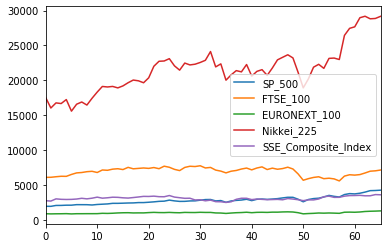

First load and transforming with underscore column names
pipehist : (90239, 9)
talenthist : (4760, 6)
revhist : (533, 3)
opphist : (422, 9)
projhist : (548, 7)
pipetrend : (1335, 4)
projectactualshist : (2364, 5)

Preparing data
x : (90239, 9)
x : (4760, 6)
x : (533, 3)
x : (422, 9)
x : (548, 7)
x : (1335, 4)
x : (2364, 5)

Preparing eom_region_snp_final
eom_region_snp_final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6912 entries, 0 to 6911
Data columns (total 8 columns):
Snapshot_Date 6912 non-null datetime64[ns]
End_of_Month 6912 non-null datetime64[ns]
Sub_Region_Code 6912 non-null object
Relative_Month_Offset 6912 non-null int64
Relative_Snapshot_Month_Offset 6912 non-null int64
Relative_EOM_Snp_Month_Offset 6912 non-null int64
Snapshot_Day_of_Month 6912 non-null int64
Snp_Seq_No 6912 non-null int64
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 432.1+ KB

count unique top freq first last mean std min 25% 50% 75% max
Snapshot_Date 6912 36 2018-11-30 00:00:00 192 2018-07-31 2021-06-14 NaN NaN NaN NaN NaN NaN NaN
End_of_Month 6912 59 2019-02-28 00:00:00 192 2017-01-31 2021-11-30 NaN NaN NaN NaN NaN NaN NaN
Sub_Region_Code 6912 8 Europe 864 NaT NaT NaN NaN NaN NaN NaN NaN NaN
Relative_Month_Offset 6912.00 NaN NaN NaN NaT NaT -24.00 12.48 -53.00 -33.00 -24.00 -15.00 5.00
Relative_Snapshot_Month_Offset 6912.00 NaN NaN NaN NaT NaT -17.50 10.39 -35.00 -26.25 -17.50 -8.75 0.00
Relative_EOM_Snp_Month_Offset 6912.00 NaN NaN NaN NaT NaT -6.50 6.92 -18.00 -12.25 -6.50 -0.75 5.00
Snapshot_Day_of_Month 6912.00 NaN NaN NaN NaT NaT 30.00 2.82 14.00 30.00 31.00 31.00 31.00
Snp_Seq_No 6912.00 NaN NaN NaN NaT NaT 7.00 0.00 7.00 7.00 7.00 7.00 7.00
Out[42]: '\neom_region_snp_pvt = eom_region_snp_final.pivot_table(\n index=[time_column_name, "Relative_EOM_Snp_Month_Offset"],\n columns=["Snp_Seq_No", "Sub_Region_Code"],\n values=["Snapshot_Date"],\n aggfunc={"Snapshot_Date": "count"},\n margins=False,\n)\n# eom_region_snp_pvt = eom_region_snp_pvt.reset_index(level=eom_region_snp_pvt.index.names).reset_index(drop=True)\n#eom_region_snp_pvt\n'

Preparing talent wide
Out[43]: '\n# pipetrend_wide.query(\'Fin_Entity_ID==@entity_debug\')\n#print("talenthist_wide:", talenthist_wide.shape)\n#talenthist_wide.tail() # .query(\'Relative_Snapshot_Month_Offset == 0\')\n'

Preparing ProjectActuals wide
Out[44]: '\n# projectactualshist_wide.query(\'Fin_Entity_ID==@entity_debug\')\nprint("projectactualshist_wide:", projectactualshist_wide.shape)\n'

Out[45]: '\nprint("Preparing Pipeline_Trend Wide")\n\nnan_value = 0\npipetrend_wide = pipetrend1.pivot_table(\n index=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"],\n columns="Pipeline_Type",\n values=["Pipeline_Trend"], # , \'Pipeline_3M_Rolling_Avg\'\n aggfunc={"Pipeline_Trend": np.sum},\n margins=False,\n).fillna(nan_value)\n\n\npipetrend_wide.columns = [\n "_".join(tuple(map(str, t))) for t in pipetrend_wide.columns.values\n]\n\npipe_cols = [\n "Active_Unrecognized_Trend",\n "Opportunity_Trend",\n "Opportunity_ML_Trend", # , "Recognized",\n]\n\npipetrend_wide.columns = pipe_cols\n\npipetrend_wide = pipetrend_wide.reset_index(\n level=pipetrend_wide.index.names\n).reset_index(drop=True)\n\nnumeric_cols_pipetrend = numeric_cols\nnumeric_cols_pipetrend = numeric_cols_pipetrend + pipe_cols\nif "Pipeline_Trend" in numeric_cols_pipetrend:\n numeric_cols_pipetrend.remove("Pipeline_Trend")\nprint(numeric_cols_pipetrend)\n\nnumeric_cols = numeric_cols_pipetrend\npipetrend_wide = convert_date_cols(pipetrend_wide)\npipetrend_wide = coerce_to_numeric(pipetrend_wide,numeric_cols)\npipetrend_wide = coerce_to_int(pipetrend_wide, int_cols)\n\npipetrend_wide = pipetrend_wide.sort_values(by=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"]).reset_index(drop=True)\n\n# print(\' pipetrend_wide: \')\n\ndisplay(pipetrend_wide.info())\n\n# pipetrend_wide.query(\'Fin_Entity_ID==@entity_debug\')\nprint("pipetrend_wide:", pipetrend_wide.shape)\n#pipetrend_wide.tail() # .query(\'Relative_Snapshot_Month_Offset == 0\')\n\n'

Preparing merge_df
merge_df: 2021-06-14 00:00:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6912 entries, 0 to 6911
Data columns (total 28 columns):
Snapshot_Date 6912 non-null datetime64[ns]
End_of_Month 6912 non-null datetime64[ns]
Sub_Region_Code 6912 non-null object
Relative_Month_Offset 6912 non-null int64
Relative_Snapshot_Month_Offset 6912 non-null int64
Relative_EOM_Snp_Month_Offset 6912 non-null int64
Snapshot_Day_of_Month 6912 non-null int64
Snp_Seq_No 6912 non-null int64
Revenue 6912 non-null float64
Project_Period_Count 6912 non-null float64
Project_Count 6912 non-null float64
Project_Period_Price 6912 non-null float64
Project_Price 6912 non-null float64
Conversions 6912 non-null float64
Opportunity_Period_Count 6912 non-null float64
Opportunity_Count 6912 non-null float64
Current_Opp_Period_Value 6912 non-null float64
Opportunity_Value 6912 non-null float64
Win_Rate 6912 non-null float64
Current_Opp_Period_Count 6912 non-null float64
Opportunity_Period_Value 6912 non-null float64
Nominal_Hours 6912 non-null float64
Utilization_Billable 6912 non-null float64
Headcount_Billable 6912 non-null float64
Headcount_Non-Billable 6912 non-null float64
Headcount_Contingent_Billable 6912 non-null float64
Headcount_Contingent_Non-Billable 6912 non-null float64
Headcount_Contingent_Unknown 6912 non-null float64
dtypes: datetime64[ns](2), float64(20), int64(5), object(1)
memory usage: 1.5+ MB

Preparing merge_df1
merge_df1: 2021-06-14 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6912 entries, 0 to 6911
Data columns (total 33 columns):
Snapshot_Date 6912 non-null datetime64[ns]
End_of_Month 6912 non-null datetime64[ns]
Sub_Region_Code 6912 non-null object
Relative_Month_Offset 6912 non-null int64
Relative_Snapshot_Month_Offset 6912 non-null int64
Relative_EOM_Snp_Month_Offset 6912 non-null int64
Snapshot_Day_of_Month 6912 non-null int64
Snp_Seq_No 6912 non-null int64
Revenue 6912 non-null float64
Project_Period_Count 6912 non-null float64
Project_Count 6912 non-null float64
Project_Period_Price 6912 non-null float64
Project_Price 6912 non-null float64
Conversions 6912 non-null float64
Opportunity_Period_Count 6912 non-null float64
Opportunity_Count 6912 non-null float64
Current_Opp_Period_Value 6912 non-null float64
Opportunity_Value 6912 non-null float64
Win_Rate 6912 non-null float64
Current_Opp_Period_Count 6912 non-null float64
Opportunity_Period_Value 6912 non-null float64
Nominal_Hours 6912 non-null float64
Utilization_Billable 6912 non-null float64
Headcount_Billable 6912 non-null float64
Headcount_Non-Billable 6912 non-null float64
Headcount_Contingent_Billable 6912 non-null float64
Headcount_Contingent_Non-Billable 6912 non-null float64
Headcount_Contingent_Unknown 6912 non-null float64
EURONEXT_100 6912 non-null float64
FTSE_100 6912 non-null float64
Nikkei_225 6912 non-null float64
SP_500 6912 non-null float64
SSE_Composite_Index 6912 non-null float64
dtypes: datetime64[ns](2), float64(25), int64(5), object(1)
memory usage: 1.7+ MB

Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_EOM_Snp_Month_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp_Period_Value,Opportunity_Value,Win_Rate,Current_Opp_Period_Count,Opportunity_Period_Value,Nominal_Hours,Utilization_Billable,Headcount_Billable,Headcount_Non-Billable,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index
2018-07-31T00:00:00.000+0000,2017-01-31T00:00:00.000+0000,Academy,-53,-35,-18,31,7,589253.5,12.0,74.0,69626.0,1708416.0,69626.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3608.0,0.0,13.0,6.3,0.0,0.0,0.0,916.7000122070312,7099.2001953125,19041.33984375,2278.8701171875,3159.166015625
2018-07-31T00:00:00.000+0000,2017-01-31T00:00:00.000+0000,Centers of Excellence,-53,-35,-18,31,7,317276.9,2.0,28.0,50000.0,1480000.0,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,916.7000122070312,7099.2001953125,19041.33984375,2278.8701171875,3159.166015625
2018-07-31T00:00:00.000+0000,2017-01-31T00:00:00.000+0000,China,-53,-35,-18,31,7,639967.43,3.0,21.0,453352.5,4897555.04,434540.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6216.0,0.37904,26.0,12.0,0.0,0.0,0.0,916.7000122070312,7099.2001953125,19041.33984375,2278.8701171875,3159.166015625
2018-07-31T00:00:00.000+0000,2017-01-31T00:00:00.000+0000,Europe,-53,-35,-18,31,7,1155943.23,9.0,298.0,922408.78,6413200.03,922408.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14600.0,0.37916,50.900000000000006,25.75,4.0,0.0,2.0,916.7000122070312,7099.2001953125,19041.33984375,2278.8701171875,3159.166015625
2018-07-31T00:00:00.000+0000,2017-01-31T00:00:00.000+0000,Global,-53,-35,-18,31,7,54366.82,5.0,188.0,47470.0,1008872.0,47470.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10520.0,0.0019999999999999996,14.0,43.8,2.0,1.0,2.0,916.7000122070312,7099.2001953125,19041.33984375,2278.8701171875,3159.166015625
2018-07-31T00:00:00.000+0000,2017-01-31T00:00:00.000+0000,Japan,-53,-35,-18,31,7,329393.07,0.0,23.0,0.0,2193225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3880.0,0.16555999999999998,18.0,1.0,0.0,0.0,2.0,916.7000122070312,7099.2001953125,19041.33984375,2278.8701171875,3159.166015625
2018-07-31T00:00:00.000+0000,2017-01-31T00:00:00.000+0000,North America,-53,-35,-18,31,7,9428262.28,84.0,841.0,1.6161338E7,6.7703268E7,1.1981645E7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49096.0,0.42122000000000004,341.5,86.6,18.0,4.0,9.0,916.7000122070312,7099.2001953125,19041.33984375,2278.8701171875,3159.166015625
2018-07-31T00:00:00.000+0000,2017-01-31T00:00:00.000+0000,Play Lab,-53,-35,-18,31,7,281876.15,18.0,48.0,0.0,426000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.6,0.0,1.0,1.0,0.0,916.7000122070312,7099.2001953125,19041.33984375,2278.8701171875,3159.166015625
2018-08-31T00:00:00.000+0000,2017-02-28T00:00:00.000+0000,Academy,-52,-34,-18,31,7,346364.75,2.0,75.0,0.0,1638790.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3520.0,0.00208,13.0,7.3,0.0,0.0,0.0,942.97998046875,7263.39990234375,19118.990234375,2363.639892578125,3241.73291015625
2018-08-31T00:00:00.000+0000,2017-02-28T00:00:00.000+0000,Centers of Excellence,-52,-34,-18,31,7,165442.92,5.0,32.0,401000.0,1856000.0,401000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,942.97998046875,7263.39990234375,19118.990234375,2363.639892578125,3241.73291015625


Preparing pipehist_wide
pipehist_wide: 2021-06-14 00:00:00
Pipehist_wide: (72478, 16)
Out[48]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline_Active_Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity_ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active_Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity_ML,Pipeline_at_100_Percent_Recognized,Yield_Active_Unrecognized,Yield_Opportunity_ML,Yield_Recognized
count,72478,72478,72478,72478.00,72478.00,72478.00,72478.00,72478.00,72478.00,72478.00,72478.00,72478.00,72478.00,72478.00,72478.00,72478.00
unique,186,65,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,2021-06-12 00:00:00,2017-03-31 00:00:00,North America,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,515,1674,10506,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
first,2018-07-20 00:00:00,2017-01-31 00:00:00,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
last,2021-06-14 00:00:00,2022-05-31 00:00:00,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,-14.61,-28.01,96512.86,48016.78,69497.49,1332468.16,96512.86,159116.99,111179.57,1332468.16,-0.01,0.07,0.42
std,NaN,NaN,NaN,9.96,16.22,646427.81,288680.78,409477.29,2826431.27,646427.81,780207.17,698789.47,2826431.27,0.09,0.56,5.57
min,NaN,NaN,NaN,-35.00,-53.00,-119607.00,0.00,0.00,-761937.07,-119607.00,0.00,0.00,-761937.07,-4.57,-1.00,-3.10
25%,NaN,NaN,NaN,-22.00,-42.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.20


Preparing merge_final
Sort Order: ['End_of_Month', 'Relative_EOM_Snp_Month_Offset', 'Snp_Seq_No', 'Sub_Region_Code']
merge_final: (6912, 45)
Out[49]:

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date,6912,36,2018-11-30 00:00:00,192,2018-07-31,2021-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
End_of_Month,6912,59,2019-02-28 00:00:00,192,2017-01-31,2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_Region_Code,6912,8,Europe,864,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,6912.00,NaN,NaN,NaN,NaT,NaT,-24.00,12.48,-53.00,-33.00,-24.00,-15.00,5.00
Relative_Snapshot_Month_Offset,6912.00,NaN,NaN,NaN,NaT,NaT,-17.50,10.39,-35.00,-26.25,-17.50,-8.75,0.00
Relative_EOM_Snp_Month_Offset,6912.00,NaN,NaN,NaN,NaT,NaT,-6.50,6.92,-18.00,-12.25,-6.50,-0.75,5.00
Snapshot_Day_of_Month,6912.00,NaN,NaN,NaN,NaT,NaT,30.00,2.82,14.00,30.00,31.00,31.00,31.00
Snp_Seq_No,6912.00,NaN,NaN,NaN,NaT,NaT,7.00,0.00,7.00,7.00,7.00,7.00,7.00
Revenue,6912.00,NaN,NaN,NaN,NaT,NaT,1801798.35,3118631.63,-520093.90,278016.63,694179.91,1222424.22,12137512.77
Project_Period_Count,6912.00,NaN,NaN,NaN,NaT,NaT,22.12,42.83,0.00,3.00,7.00,14.00,250.00


Out[51]: Timestamp('2021-06-14 00:00:00')

In [0]:
%run ./data_prep_rev_region_forecast

In [0]:

# Import the Workspace class and configure your local envionment
from azureml.core import Workspace

# from azureml.core.authentication import InteractiveLoginAuthentication
import os
from azureml.core.authentication import ServicePrincipalAuthentication

tenant_id = "cfa930ff-a3f0-4933-8cea-744f8ead7682"

if environment == "prod":
    svc_pr_password = dbutils.secrets.get(
        scope="kv-bi-prod-01-secrets", key="dbw-azureml-prod-key"
    )
    service_principal_id = "23bd5a19-b0e0-44af-9320-24b578ec0f74"
else:
    svc_pr_password = dbutils.secrets.get(
        scope="kv-bi-devqa-01-secrets", key="dbw-azureml-devqa-key"
    )
    service_principal_id = "626c2c00-26de-46ee-a20d-6027445518ff"
    


svc_pr = ServicePrincipalAuthentication(
    tenant_id=tenant_id,
    service_principal_id=service_principal_id,
    service_principal_password=svc_pr_password,
)

# Create Workspace if required
"""
from azureml.core import Workspace

ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,                      
                      exist_ok=True)
ws.get_details()

"""

try:
    ws = Workspace(
        workspace_name=workspace_name,
        subscription_id=subscription_id,
        resource_group=resource_group,
        auth=svc_pr,  # forced_interactive_auth
    )

    # Persist the subscription id, resource group name, and workspace name in aml_config/config.json.
    ws.write_config()
    print(ws)
    print("Found workspace {} at location {}".format(ws.name, ws.location))
    
    print("workspace_name",workspace_name)
    print("subscription_id",subscription_id)
    print("resource_group",resource_group)
    print("svc_pr",svc_pr)
    print("service_principal_id",service_principal_id)
    print("svc_pr_password",svc_pr_password)

    # ws.write_config(path="./aml_config/",file_name="ws_config.json")
    # use the get method to load an existing workspace without using configuration files.
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    #raise dbutils.notebook.exit(error) #raise the exception
    raise error #raise the exception



Workspace.create(name='mlw-bi-automl-devqa01', subscription_id='[REDACTED]', resource_group='rg-bi-automl-devqa01')
Found workspace mlw-bi-automl-devqa01 at location westus
workspace_name mlw-bi-automl-devqa01
subscription_id [REDACTED]
resource_group rg-bi-automl-devqa01
svc_pr <azureml.core.authentication.ServicePrincipalAuthentication object at 0x7fdfc1fd5750>
service_principal_id 626c2c00-26de-46ee-a20d-6027445518ff
svc_pr_password [REDACTED]

In [0]:

# Create an experiement
import os
import random
import time
import json

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from azureml.automl.core.featurization import FeaturizationConfig

# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.ipynb
# Choose a name for the experiment and specify the project folder.
experiment_name = "automl-revenue-region-forecast"

try:

    experiment = Experiment(ws, experiment_name)

    output = {}
    output["SDK version"] = azureml.core.VERSION
    output["Subscription ID"] = ws.subscription_id
    output["Workspace Name"] = ws.name
    output["Resource Group"] = ws.resource_group
    output["Location"] = ws.location
    output["Experiment Name"] = experiment.name
    pd.set_option("display.max_colwidth", -1)
    print(pd.DataFrame(data=output, index=[""]).T)
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    raise dbutils.notebook.exit(error) #raise the exception
    
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU clustera
try:
    amlcompute_cluster_name = aml_compute_cluster_name

    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print("Found existing cluster, use it:", amlcompute_cluster_name)
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    #raise dbutils.notebook.exit(error) #raise the exception
    raise error #raise the exception



SDK version 1.30.0 
Subscription ID [REDACTED]
Workspace Name mlw-bi-automl-devqa01 
Resource Group rg-bi-automl-devqa01 
Location westus 
Experiment Name automl-revenue-region-forecast 
Found existing cluster, use it: cc-bi-ml-devqa01

In [0]:

# Data Split
# split the data into a training and a testing set for later forecast evaluation. The test set will contain the final test_size months of observed sales for each time-series.
# The splits should be stratified by series, so we use a group-by statement on the time series identifier columns.
# test_size = .11 #in percentage
# n_test_periods =  int(tseries * test_size)
# n_test_periods = Relative_EOM_Snp_Month_Offset_future_period

df = merge_final.copy()
'''
tseries = df.groupby(time_column_name).ngroups
print("Data contains {0} individual time_column_name.".format(tseries))
test_size = round(n_test_periods / tseries, 2)
print("Time Column Name:", time_column_name)
print("Test Size: ", test_size, "Test Periods: ", n_test_periods)
print(df[time_column_name].unique())

#print("n_test_periods: ", n_test_periods)
'''

train = df.query("Relative_Month_Offset < 0")
test = df.drop(train.index)

#(train, test) = split_last_n_by_series_id(df, n_test_periods)

print(df.shape)
print(train.shape)
print(test.shape)

train.to_csv(output_data_path + "revregionforecast_train.csv", index=None, header=True)
test.to_csv(output_data_path + "revregionforecast_test.csv", index=None, header=True)

(6912, 45)
(6744, 45)
(168, 45)

In [0]:

# Summary Stats for Train and Test dataframes

print("Train************************")
#print(train.info(verbose=True))
train.describe(include="all").transpose().head()
#train.tail(10)



Train************************
Out[55]:

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date,6744,36,2018-11-30 00:00:00,192,2018-07-31,2021-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
End_of_Month,6744,53,2019-12-31 00:00:00,192,2017-01-31,2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_Region_Code,6744,8,Europe,843,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,6744.00,NaN,NaN,NaN,NaT,NaT,-24.64,11.95,-53.00,-33.00,-24.00,-16.00,-1.00
Relative_Snapshot_Month_Offset,6744.00,NaN,NaN,NaN,NaT,NaT,-17.89,10.21,-35.00,-27.00,-18.00,-9.00,0.00


In [0]:

print("Test************************")
#print(test.info(verbose=True))
test.describe(include="all").transpose().head()
#test.tail(10)



Test************************
Out[56]:

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date,168,6,2021-06-14 00:00:00,48,2021-01-31,2021-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
End_of_Month,168,6,2021-06-30 00:00:00,48,2021-06-30,2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_Region_Code,168,8,North America,21,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,168.00,NaN,NaN,NaN,NaT,NaT,1.67,1.50,0.00,0.00,1.00,3.00,5.00
Relative_Snapshot_Month_Offset,168.00,NaN,NaN,NaN,NaT,NaT,-1.67,1.50,-5.00,-3.00,-1.00,0.00,0.00


In [0]:

# plot the example time series
#!pip install seaborn
"""
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# sns.set_context('paper', font_scale=1.3)
# sns.set_style('white')

(fig, ax) = plt.subplots(figsize=(24, 9))
import matplotlib.pyplot as plt
whole_data = train.copy()
target_label = target_column_name
whole_data[target_label] = train[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
plt.legend()
#plt.show()

# plot the example time series

(fig, ax) = plt.subplots(figsize=(24, 9))
import matplotlib.pyplot as plt
whole_data = test.copy()
target_label = target_column_name
whole_data[target_label] = test[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
plt.legend()
#plt.show()
"""



Out[57]: "\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\npd.set_option('display.float_format', lambda x: '%.4f' % x)\n\n# sns.set_context('paper', font_scale=1.3)\n# sns.set_style('white')\n\n(fig, ax) = plt.subplots(figsize=(24, 9))\nimport matplotlib.pyplot as plt\nwhole_data = train.copy()\ntarget_label = target_column_name\nwhole_data[target_label] = train[target_column_name]\nfor g in whole_data.groupby(time_series_id_column_names):\n plt.plot(g[1][time_column_name].values,\n g[1][target_column_name].values, label=g[0])\nplt.legend()\n#plt.show()\n\n# plot the example time series\n\n(fig, ax) = plt.subplots(figsize=(24, 9))\nimport matplotlib.pyplot as plt\nwhole_data = test.copy()\ntarget_label = target_column_name\nwhole_data[target_label] = test[target_column_name]\nfor g in whole_data.groupby(time_series_id_column_names):\n plt.plot(g[1][time_column_name].values,\n g[1][target_column_name].values, label=g[0])\nplt.legend()\n#plt.show()\n"

In [0]:

# Create dataset for training

from azureml.core import Dataset, Datastore

datastore = ws.get_default_datastore()
print("Default datastore's name: {}".format(datastore.name))

# register_spark_dataframe(dataframe=train_sdf, target=blobstore_datadir, name="revforecast_train.parquet", description=None, tags=None, show_progress=True)

datastore.upload_files(
    files=[
        output_data_path + "revregionforecast_train.csv",
        output_data_path + "revregionforecast_test.csv",
    ],
    target_path=blobstore_datadir,
    overwrite=True,
    show_progress=True,
)

dataset_filename = blobstore_datadir + "revregionforecast_train.csv"
train_dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, dataset_filename)]
)

#display(train_dataset.to_pandas_dataframe().head())
display(train_dataset.to_pandas_dataframe().tail())



Default datastore's name: workspaceblobstore
Uploading an estimated of 2 files
Uploading /dbfs/mnt/dev/automl_rev_region_forecast/outputs/revregionforecast_train.csv
Uploaded /dbfs/mnt/dev/automl_rev_region_forecast/outputs/revregionforecast_train.csv, 1 files out of an estimated total of 2
Uploading /dbfs/mnt/dev/automl_rev_region_forecast/outputs/revregionforecast_test.csv
Uploaded /dbfs/mnt/dev/automl_rev_region_forecast/outputs/revregionforecast_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files

Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_EOM_Snp_Month_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp_Period_Value,Opportunity_Value,Win_Rate,Current_Opp_Period_Count,Opportunity_Period_Value,Nominal_Hours,Utilization_Billable,Headcount_Billable,Headcount_Non-Billable,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend,Pipeline_Active_Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity_ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active_Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity_ML,Pipeline_at_100_Percent_Recognized,Yield_Active_Unrecognized,Yield_Opportunity_ML,Yield_Recognized
2021-06-14T00:00:00.000+0000,2021-05-31T00:00:00.000+0000,Europe,-1,0,-1,14,7,1735243.5,3.0,32.0,1442322.6,1.119030293E7,148004.85,7.0,31.0,1681921.45,1.36441948E7,0.2826,7.0,1009955.0,13309.6,0.45686,55.0,24.5,5.0,2.0,3.0,1248.9300537109375,7022.60009765625,28860.080078125,4204.10986328125,3615.47998046875,4591844.75,0.0,0.0,0.0,1735243.48,0.0,0.0,0.0,1735243.48,0.0,0.0,-0.0502
2021-06-14T00:00:00.000+0000,2021-05-31T00:00:00.000+0000,Global,-1,0,-1,14,7,94706.07,12.0,140.0,1404425.0,7669281.0,-7591.0,0.0,3.0,0.0,723661.0,0.0,0.0,0.0,9576.0,0.006500000000000001,19.7,42.6,2.0,1.0,1.0,1248.9300537109375,7022.60009765625,28860.080078125,4204.10986328125,3615.47998046875,382234.48,0.0,0.0,0.0,94706.1,0.0,0.0,0.0,94706.1,0.0,0.0,-0.3491
2021-06-14T00:00:00.000+0000,2021-05-31T00:00:00.000+0000,Japan,-1,0,-1,14,7,722931.15,7.0,28.0,1263840.0,7970122.72,499783.68,10.0,29.0,1390872.73,3869624.73,0.0,10.0,579600.0,5904.0,0.23682000000000003,34.0,4.0,0.0,0.0,4.0,1248.9300537109375,7022.60009765625,28860.080078125,4204.10986328125,3615.47998046875,2040944.29,0.0,0.0,0.0,722931.15,0.0,0.0,0.0,722931.15,0.0,0.0,-0.0239
2021-06-14T00:00:00.000+0000,2021-05-31T00:00:00.000+0000,North America,-1,0,-1,14,7,7966673.43,95.0,350.0,5.0481661E7,1.1733815E8,1.1928565E7,51.0,152.0,1.667682E7,5.7457846E7,0.1094,51.0,8841001.0,55392.0,0.38636000000000004,257.95,66.3,35.0,14.0,4.0,1248.9300537109375,7022.60009765625,28860.080078125,4204.10986328125,3615.47998046875,2.880820104E7,0.0,0.0,0.0,7966672.47,0.0,0.0,0.0,7966672.47,0.0,0.0,0.0382
2021-06-14T00:00:00.000+0000,2021-05-31T00:00:00.000+0000,Play Lab,-1,0,-1,14,7,533934.46,1.0,20.0,390000.0,452784.0,0.0,2.0,5.0,0.0,390000.0,0.0,2.0,0.0,3648.0,0.24500000000000002,20.0,2.0,0.0,1.0,0.0,1248.9300537109375,7022.60009765625,28860.080078125,4204.10986328125,3615.47998046875,704650.35,0.0,0.0,0.0,533934.46,0.0,0.0,0.0,533934.46,0.0,0.0,-0.0129


In [0]:
# Set forecasting_parameters for training

from azureml.automl.core.forecasting_parameters import ForecastingParameters

target_lag = "auto"  # [x for x in range(1,7)] #'auto'
window_size = "auto"
feature_lag = "auto"
forecast_horizon = n_test_periods

print("past_period", past_period)
print("n_test_periods", n_test_periods)
print("target_lags:", target_lag)
print("target_rolling_window_size:", window_size)
print("forecast_horizon:", forecast_horizon)
print("feature_lags:", feature_lag)

forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    time_series_id_column_names=time_series_id_column_names,
    target_lags=target_lag,
    feature_lags=feature_lag,
    target_rolling_window_size=window_size,
    drop_column_names = ['Project_Period_Count','Project_Period_Price','Opportunity_Period_Count','Current_Opp_Period_Value',
                         'Current_Opp_Period_Count','Opportunity_Period_Value','Utilization_Billable','Yield_Recognized']
)

# drop_column_names = ['-1M Pipeline']

automl_config = AutoMLConfig(  # featurization_config,
    task="forecasting",
    debug_log="rev_region_forecast_errors.log",
    primary_metric="normalized_root_mean_squared_error",
    experiment_timeout_hours=4,
    training_data=train_dataset,
    label_column_name=target_column_name,
    enable_early_stopping=True,
    #spark_context=sc, #enable this for databricks cluster
    compute_target=compute_target,  # enable this for ml cluster
    enable_dnn=True,  # enable this for ml cluster
    featurization="auto",
    n_cross_validations=5,
    verbosity=logging.INFO,
    max_concurrent_iterations=20,
    max_cores_per_iteration=-1,
    forecasting_parameters=forecasting_parameters,
)

past_period 18
n_test_periods 6
target_lags: auto
target_rolling_window_size: auto
forecast_horizon: 6
feature_lags: auto
WARNING:root:Parameter 'drop_column_names' will be deprecated. Please drop columns from your datasets as part of your data preparation process before providing the datasets to AutoML.

In [0]:

# submit a new training run
from azureml.train.automl.run import AutoMLRun

try:
    if new_training == "True":
        print("New Training Run")
        remote_run = experiment.submit(automl_config, show_output=True)
    else:
        # If you need to retrieve a run that already started, use the following code
        print("Existing Training Run")
        remote_run = AutoMLRun(
            experiment=experiment, run_id = runid
        )
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    #raise dbutils.notebook.exit(error) #raise the exception
    raise error #raise the exception

remote_run

Existing Training Run
Out[60]:

Experiment,Id,Type,Status,Details Page,Docs Page
automl-revenue-region-forecast,AutoML_35b909cf-97e9-47f7-8040-6df861e5efba,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [0]:

# Get run_id and run_datetime
rr = remote_run.wait_for_completion()
run_id = rr.get("runId")
run_datetime = rr.get("endTimeUtc")
print(run_id, run_datetime)

# Retrieve the Best Model
try:
    best_run, fitted_model = remote_run.get_output()
    print("Best Run Model: ", best_run)
    #print(fitted_model.steps)
    model_name = best_run.properties["model_name"]
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    #raise dbutils.notebook.exit(error) #raise the exception
    raise error #raise the exception
# print ('Model Name: ', model_name)



AutoML_35b909cf-97e9-47f7-8040-6df861e5efba 2021-06-14T18:34:37.831933Z
Best Run Model: Run(Experiment: automl-revenue-region-forecast,
Id: AutoML_35b909cf-97e9-47f7-8040-6df861e5efba_564,
Type: azureml.scriptrun,
Status: Completed)

In [0]:
# View updated featurization summary
# Transparency
try:
    featurization_summary = fitted_model.named_steps[
        "timeseriestransformer"
    ].get_featurization_summary()

    # View the featurization summary as a pandas dataframe

    fs = pd.DataFrame.from_records(featurization_summary)
    fs.reset_index(inplace=True, drop=True)
    fs_filename = (
    output_data_path
    + "./featurization_summary.csv"
    )
    fs.to_csv(fs_filename, header=True, index=False) 
    fs.tail(10)
    
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    #raise dbutils.notebook.exit(error) #raise the exception
    raise error #raise the exception




In [0]:

# Get metrics for best run
try:
    pd.set_option("display.float_format", lambda x: "%.5f" % x)
    metricslist = {}
    properties = best_run.get_properties()
    # print(properties)
    metrics = {k: v for k, v in best_run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties["iteration"])] = metrics
    rundata = pd.DataFrame.from_records(metricslist).sort_index(1)
    rundata.reset_index(inplace=True)
    rundata.rename(columns={"index": "Metric"}, inplace=True)

    rundata_filename = (
        output_data_path + "./rundata_metrics.csv"
        )
    rundata.to_csv(rundata_filename, header=True, index=False) 
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    #raise dbutils.notebook.exit(error) #raise the exception
    raise error #raise the exception
rundata

Out[63]:

,Metric,564
0,explained_variance,0.98815
1,mean_absolute_error,115815.02756
2,mean_absolute_percentage_error,23.93387
3,median_absolute_error,5634.12166
4,normalized_mean_absolute_error,0.09266
5,normalized_median_absolute_error,0.07582
6,normalized_root_mean_squared_error,0.11792
7,normalized_root_mean_squared_log_error,0.10880
8,r2_score,0.98803
9,root_mean_squared_error,313695.29358


In [0]:

# FORECASTING

X_test = test.copy()
y_test = X_test.pop(target_column_name).values

# forecast returns the predictions and the featurized data, aligned to X_test.
# This contains the assumptions that were made in the forecast
# The featurized data, aligned to y, will also be returned.
# and helps align the forecast to the original data
try:
    y_predictions, X_trans = fitted_model.forecast(X_test)

    # from forecasting_helper import align_outputs

    df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)
    df_all.rename(columns={"predicted": "Predicted_Revenue"}, inplace=True)
    df_all["Predicted_Revenue"] = np.round(df_all["Predicted_Revenue"],2)
    df_all.info()
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    #raise dbutils.notebook.exit(error) #raise the exception
    raise error #raise the exception



<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 167
Data columns (total 48 columns):
End_of_Month 168 non-null datetime64[ns]
Relative_EOM_Snp_Month_Offset 168 non-null int64
Snp_Seq_No 168 non-null int64
Sub_Region_Code 168 non-null object
origin 168 non-null datetime64[ns]
Predicted_Revenue 168 non-null float64
horizon_origin 168 non-null int64
Snapshot_Date 168 non-null datetime64[ns]
Relative_Month_Offset 168 non-null int64
Relative_Snapshot_Month_Offset 168 non-null int64
Snapshot_Day_of_Month 168 non-null int64
Project_Period_Count 168 non-null float64
Project_Count 168 non-null float64
Project_Period_Price 168 non-null float64
Project_Price 168 non-null float64
Conversions 168 non-null float64
Opportunity_Period_Count 168 non-null float64
Opportunity_Count 168 non-null float64
Current_Opp_Period_Value 168 non-null float64
Opportunity_Value 168 non-null float64
Win_Rate 168 non-null float64
Current_Opp_Period_Count 168 non-null float64
Opportunity_Period_Value 168 non-null float64
Nominal_Hours 168 non-null float64
Utilization_Billable 168 non-null float64
Headcount_Billable 168 non-null float64
Headcount_Non-Billable 168 non-null float64
Headcount_Contingent_Billable 168 non-null float64
Headcount_Contingent_Non-Billable 168 non-null float64
Headcount_Contingent_Unknown 168 non-null float64
EURONEXT_100 168 non-null float64
FTSE_100 168 non-null float64
Nikkei_225 168 non-null float64
SP_500 168 non-null float64
SSE_Composite_Index 168 non-null float64
Pipeline_Trend 168 non-null float64
Pipeline_Active_Unrecognized 168 non-null float64
Pipeline_Opportunity 168 non-null float64
Pipeline_Opportunity_ML 168 non-null float64
Pipeline_Recognized 168 non-null float64
Pipeline_at_100_Percent_Active_Unrecognized 168 non-null float64
Pipeline_at_100_Percent_Opportunity 168 non-null float64
Pipeline_at_100_Percent_Opportunity_ML 168 non-null float64
Pipeline_at_100_Percent_Recognized 168 non-null float64
Yield_Active_Unrecognized 168 non-null float64
Yield_Opportunity_ML 168 non-null float64
Yield_Recognized 168 non-null float64
Revenue 168 non-null float64
dtypes: datetime64[ns](3), float64(38), int64(6), object(1)
memory usage: 64.3+ KB

[Test data scores]
root_mean_squared_error: 3054017.554
normalized_root_mean_squared_error: 1.000
normalized_root_mean_squared_log_error: nan
r2_score: -1.000
root_mean_squared_log_error: nan
explained_variance: -53.600
median_absolute_error: 706510.850
mean_absolute_error: 1622086.461
mean_absolute_percentage_error: 44446.920
normalized_mean_absolute_error: 1.000
spearman_correlation: 0.060
normalized_median_absolute_error: 0.561

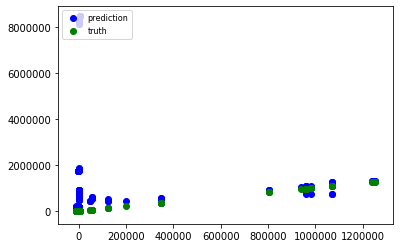

In [0]:
# Evaluate
# To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

# We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.

#assign_dict = {'Predicted_Revenue': y_predictions, target_column_name: y_test}
#df_all = X_test.assign(**assign_dict)
#df_all.tail(10)

from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module

scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all["Predicted_Revenue"],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET),
)

print("[Test data scores]")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

# Plot outputs

#%matplotlib inline
test_pred = plt.scatter(
    df_all[target_column_name], df_all["Predicted_Revenue"], color="b"
)
test_test = plt.scatter(
    df_all[target_column_name], df_all[target_column_name], color="g"
)
plt.legend(
    (test_pred, test_test), ("prediction", "truth"), loc="upper left", fontsize=8
)
plt.show()

TRUE

MAPE,RMSE,MAE,R2_SCORE
81376.4848870327,3096479.800753722,1660825.906875,-94.92318632035028
38.463430946746854,3053924.435932699,1618080.5552499997,-72.59993159918747
137.5068160403557,3046813.8295121337,1610008.638125,-88.70397644776565
385.5803047212221,3029632.1721853204,1616036.4620833334,-130.36264093361808
4.468940882022433,2982796.632494923,1559989.7937500002,-29.67804182309799
63.61426975737476,3040333.797022423,1600333.9412500001,-95.96183830876322


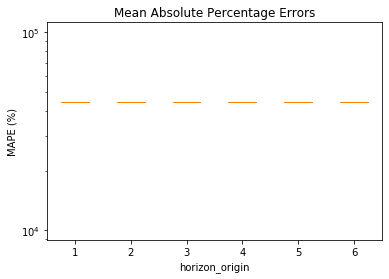

In [0]:
# Print metrics by different groups

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#print(df_all.info())
if "horizon_origin" in df_all.columns:
    group_by = "horizon_origin"
    print("TRUE")
else:
    group_by = "Relative_EOM_Snp_Month_Offset"

df_mpae = df_all.groupby(group_by).apply(
    lambda df: pd.Series(
        {
            "MAPE": MAPE(df[target_column_name], df["Predicted_Revenue"]),
            "RMSE": np.sqrt(
                mean_squared_error(df[target_column_name], df["Predicted_Revenue"])
            ),
            "MAE": mean_absolute_error(df[target_column_name], df["Predicted_Revenue"]),
            "R2_SCORE": r2_score(df[target_column_name], df["Predicted_Revenue"]),
        }
    )
)
display(df_mpae)

# Box plot with different groups
df_all_MAPE = df_all.assign(
    MAPE = MAPE(df_all[target_column_name], df_all["Predicted_Revenue"])
)

MAPEs = [df_all_MAPE[df_all[group_by] == h].MAPE.values for h in range(1, forecast_horizon + 1)]


#%matplotlib inline
plt.boxplot(MAPEs)
plt.yscale("log")
plt.xlabel(group_by)
plt.ylabel("MAPE (%)")
plt.title("Mean Absolute Percentage Errors")

plt.show()

In [0]:

# Confidence intervals
"""
quantiles = fitted_model.forecast_quantiles(X_test)
# quantiles.tail(10)

# specify which quantiles you would like

fitted_model.quantiles = [0.01, 0.5, 0.8, 0.95]

# use forecast_quantiles function, not the forecast() one

y_pred_quantiles =  fitted_model.forecast_quantiles(X_test)

# quantile forecasts returned in a Dataframe along with the time and time series id columns 

#y_pred_quantiles.tail(10)
"""



Out[67]: '\nquantiles = fitted_model.forecast_quantiles(X_test)\n# quantiles.tail(10)\n\n# specify which quantiles you would like\n\nfitted_model.quantiles = [0.01, 0.5, 0.8, 0.95]\n\n# use forecast_quantiles function, not the forecast() one\n\ny_pred_quantiles = fitted_model.forecast_quantiles(X_test)\n\n# quantile forecasts returned in a Dataframe along with the time and time series id columns \n\n#y_pred_quantiles.tail(10)\n'

In [0]:

# Merge df_all with train

from functools import reduce

# Get the column index list in the right order

cols_sort_list = list(df_all.columns)
#print(cols_sort_list)
# df_all.tail(10)

nan_value = 0
merge_dfs = [train, df_all]

final_merge_df = train.append(df_all, ignore_index=True, sort=False).sort_values(
    by=final_sort_order, ascending=final_sort_order_ascending
)

final_merge_df = final_merge_df.replace(np.nan, 0, regex=True)

final_merge_df["Relative_Month_Offset"] = round(
    (final_merge_df["End_of_Month"] - current_eom) / np.timedelta64(1, "M"), 0
).astype(int)

if "origin" in final_merge_df.columns:
    final_merge_df["origin"] = pd.to_datetime(final_merge_df["origin"])

    # .dt.date

# sort using original cols_sort_list

final_merge_df = final_merge_df.sort_values(by=final_sort_order, ascending=final_sort_order_ascending).reset_index(drop=True)
final_merge_df = final_merge_df.reindex(columns=cols_sort_list)

# add new cols
final_merge_df.insert(0,"Forecast_Date", today)
final_merge_df["Run_Date"] = pd.to_datetime(run_datetime).normalize().date()
final_merge_df["Run_ID"] = run_id
final_merge_df["Currency_Code"] = "USD"

#final_merge_df = df_crossjoin(final_merge_df, rundata.query("Metric == 'normalized_root_mean_squared_error'").iloc[:, 1])
#final_merge_df = final_merge_df.reset_index(drop=True)
'''
final_merge_df["NRMSE"] = rundata.query("Metric == 'normalized_root_mean_squared_error'").iloc[:, 1]
final_merge_df["RMSE"] = rundata.query("Metric == 'root_mean_squared_error'").iloc[:, 1]
final_merge_df["R2_Score"] = rundata.query("Metric == 'r2_score'").iloc[:, 1]
final_merge_df["Explained_Variance"] = rundata.query("Metric == 'explained_variance'").iloc[:, 1]
final_merge_df["MAE"] = rundata.query("Metric == 'mean_absolute_error'").iloc[:, 1]
final_merge_df["MAPE"] = rundata.query("Metric == 'mean_absolute_percentage_error'").iloc[:, 1]
final_merge_df["Spearman_Correlation"] = rundata.query("Metric == 'spearman_correlation'").iloc[:, 1]
'''
final_merge_df = final_merge_df.reset_index(drop=True)

move_column_inplace(final_merge_df, 'Forecast_Date', 0)
move_column_inplace(final_merge_df, 'Snapshot_Date', 1)
move_column_inplace(final_merge_df, 'End_of_Month', 2)
move_column_inplace(final_merge_df, 'Sub_Region_Code', 3)
move_column_inplace(final_merge_df, 'Relative_Month_Offset', 4)
move_column_inplace(final_merge_df, 'Relative_Snapshot_Month_Offset', 5)
move_column_inplace(final_merge_df, 'Relative_EOM_Snp_Month_Offset', 6)
move_column_inplace(final_merge_df, 'Snapshot_Day_of_Month', 7)
move_column_inplace(final_merge_df, 'Snp_Seq_No', 8)
move_column_inplace(final_merge_df, 'Currency_Code', 9)
move_column_inplace(final_merge_df, 'Predicted_Revenue', 10)
move_column_inplace(final_merge_df, 'Revenue', 11)

# Cross join with rundata series to populate training metrics columns
metrics_df = pd.DataFrame(rundata).transpose()
new_header = metrics_df.iloc[0] 
metrics_df = metrics_df[1:]
metrics_df.columns = new_header
metrics_df.columns = metrics_df.columns.str.title()
final_merge_df = df_crossjoin(final_merge_df, metrics_df)

final_merge_df = movecol(final_merge_df, 
             cols_to_move=['origin','horizon_origin','Current_Opp_Period_Count','Opportunity_Period_Value'], 
             ref_col='Spearman_Correlation',
             place='After')

'''
final_merge_df["Predicted_Revenue_Variance"] = np.where(
    final_merge_df["Relative_Month_Offset"] < 0,
    final_merge_df["Revenue"] - final_merge_df["Predicted_Revenue"],
    np.nan,
)
final_merge_df["Predicted_Revenue_Variance_Percent"] = np.where(
    final_merge_df["Relative_Month_Offset"] < 0,
    round(
        final_merge_df["Predicted_Revenue_Variance"]
        / final_merge_df["Predicted_Revenue"]
        * 100,
        ndigits=4,
    ),
    np.nan,
)
final_merge_df["Predicted_Revenue_Variance"].where(
    final_merge_df["Predicted_Revenue"] != 0, np.nan, inplace=True
)
final_merge_df["Predicted_Revenue_Variance_Percent"].where(
    final_merge_df["Predicted_Revenue"] != 0, np.nan, inplace=True
)
final_merge_df["Predicted_Revenue_Variance_Percent"] = round(
    final_merge_df["Predicted_Revenue_Variance_Percent"], ndigits=4
)
'''

new_cols = ["Predicted_Revenue","Explained_Variance","Mean_Absolute_Error","Mean_Absolute_Percentage_Error","Median_Absolute_Error","Normalized_Mean_Absolute_Error",
            "Normalized_Root_Mean_Squared_Error","Normalized_Root_Mean_Squared_Log_Error","R2_Score","Root_Mean_Squared_Error","Root_Mean_Squared_Error","Root_Mean_Squared_Log_Error","Spearman_Correlation"]

numeric_cols_final_merge = numeric_cols + new_cols
#if "Billable_Headcount" in numeric_cols_final_merge:
#    numeric_cols_final_merge.remove("Billable_Headcount")
#print(numeric_cols_final_merge)

numeric_cols = numeric_cols_final_merge
final_merge_df = convert_date_cols(final_merge_df)
final_merge_df = coerce_to_numeric(final_merge_df, numeric_cols)
final_merge_df = coerce_to_int(final_merge_df, int_cols)

print(" final_merge_df: ")
display(final_merge_df.tail())
final_merge_df.to_csv(output_data_path + "final_merge_df.csv", index=False)
final_merge_df.to_parquet(output_data_path + "final_merge_df.parquet", index=None)


final_merge_df:

Forecast_Date,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_EOM_Snp_Month_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Currency_Code,Predicted_Revenue,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp_Period_Value,Opportunity_Value,Win_Rate,Nominal_Hours,Utilization_Billable,Headcount_Billable,Headcount_Non-Billable,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend,Pipeline_Active_Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity_ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active_Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity_ML,Pipeline_at_100_Percent_Recognized,Yield_Active_Unrecognized,Yield_Opportunity_ML,Yield_Recognized,Run_Date,Run_ID,Explained_Variance,Mean_Absolute_Error,Mean_Absolute_Percentage_Error,Median_Absolute_Error,Normalized_Mean_Absolute_Error,Normalized_Median_Absolute_Error,Normalized_Root_Mean_Squared_Error,Normalized_Root_Mean_Squared_Log_Error,R2_Score,Root_Mean_Squared_Error,Root_Mean_Squared_Log_Error,Spearman_Correlation,origin,horizon_origin,Current_Opp_Period_Count,Opportunity_Period_Value
2021-06-14T00:00:00.000+0000,2021-06-14T00:00:00.000+0000,2021-11-30T00:00:00.000+0000,Europe,5,0,5,14,7,USD,1819376.53,0.0,0.0,30.0,0.0,1.167354442E7,0.0,0.0,31.0,0.0,1.24337228E7,0.0,14752.0,0.0,55.0,25.5,5.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,4591844.75,394461.8,256970.56,44638.97,0.0,394461.8,549129.75,59518.62,0.0,0.047400000000000005,-0.0329,0.0,2021-06-14,AutoML_35b909cf-97e9-47f7-8040-6df861e5efba,0.988149005009598,115815.02756224145,23.93386779473483,5634.121658665443,0.09265910839215756,0.07581915856810703,0.11792133449529649,0.10880467963229686,0.9880290687184434,313695.29357898014,0.0,0.965080474063601,2021-05-31T00:00:00.000+0000,6.0,0.0,0.0
2021-06-14T00:00:00.000+0000,2021-06-14T00:00:00.000+0000,2021-11-30T00:00:00.000+0000,Global,5,0,5,14,7,USD,124910.12,0.0,0.0,51.0,0.0,2553298.0,0.0,0.0,2.0,0.0,340061.0,0.0,9211.2,0.0,21.7,41.6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,382234.48,15336.81,0.0,2663.26,0.0,15336.81,0.0,2663.26,0.0,0.1009,-0.032,0.0,2021-06-14,AutoML_35b909cf-97e9-47f7-8040-6df861e5efba,0.988149005009598,115815.02756224145,23.93386779473483,5634.121658665443,0.09265910839215756,0.07581915856810703,0.11792133449529649,0.10880467963229686,0.9880290687184434,313695.29357898014,0.0,0.965080474063601,2021-05-31T00:00:00.000+0000,6.0,0.0,0.0
2021-06-14T00:00:00.000+0000,2021-06-14T00:00:00.000+0000,2021-11-30T00:00:00.000+0000,Japan,5,0,5,14,7,USD,834469.71,0.0,0.0,30.0,0.0,8162712.17,0.0,0.0,23.0,0.0,4653500.0,0.0,6400.0,0.0,33.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2040944.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-06-14,AutoML_35b909cf-97e9-47f7-8040-6df861e5efba,0.988149005009598,115815.02756224145,23.93386779473483,5634.121658665443,0.09265910839215756,0.07581915856810703,0.11792133449529649,0.10880467963229686,0.9880290687184434,313695.29357898014,0.0,0.965080474063601,2021-05-31T00:00:00.000+0000,6.0,0.0,0.0
2021-06-14T00:00:00.000+0000,2021-06-14T00:00:00.000+0000,2021-11-30T00:00:00.000+0000,North America,5,0,5,14,7,USD,8293887.84,0.0,0.0,270.0,0.0,1.12589986E8,0.0,0.0,137.0,0.0,5.2362966E7,0.0,53112.4,0.0,252.95,64.3,25.0,19.0,6.0,0.0,0.0,0.0,0.0,0.0,2.880820104E7,1077307.4,864470.41,1097995.83,0.0,1077307.4,2850625.76,1578294.95,0.0,0.0529,0.1298,0.0,2021-06-14,AutoML_35b909cf-97e9-47f7-8040-6df861e5efba,0.988149005009598,115815.02756224145,23.93386779473483,5634.121658665443,0.09265910839215756,0.07581915856810703,0.11792133449529649,0.10880467963229686,0.9880290687184434,313695.29357898014,0.0,0.965080474063601,2021-05-31T00:00:00.000+0000,6.0,0.0,0.0
2021-06-14T00:00:00.000+0000,2021-06-14T00:00:00.000+0000,2021-11-30T00:00:00.000+0000,Play Lab,5,0,5,14,7,USD,433784.31,200000

In [0]:

# pivot by EOM1, Fin_Entity_ID
pd.set_option("display.float_format", lambda x: "%.2f" % x)  #

#final_cond = "Relative_Snapshot_Month_Offset == 0 and Snp_Seq_No == 6"

final_merge_df1 = final_merge_df.copy() #query(final_cond)

cols = [
    "Predicted_Revenue",
    "Revenue",
    "Pipeline_Recognized",
    "Pipeline_Active_Unrecognized",
    "Pipeline_Opportunity_ML",
    "Pipeline_Opportunity"]
# final_cond = "Relative_EOM_Snp_Month_Offset >= 0 and Relative_Snapshot_Month_Offset <= -3"
# final_merge_df1 = final_merge_df.query(final_cond)

final_merge_df1 = convert_date_cols(final_merge_df1)

final_merge_pivot1 = final_merge_df1.pivot_table(
    index=[
        "Forecast_Date",
        "Snapshot_Date",
        "End_of_Month",
        "Relative_Snapshot_Month_Offset",
        "Relative_Month_Offset",
        "Relative_EOM_Snp_Month_Offset",
        "Snp_Seq_No"
    ],
    values=cols,
    aggfunc={
        "Predicted_Revenue": np.sum,
        "Revenue": np.sum,
        "Pipeline_Recognized": np.sum,
        "Pipeline_Active_Unrecognized": np.sum,
        "Pipeline_Opportunity_ML": np.sum,
        "Pipeline_Opportunity": np.sum
    },
    margins=None,
).fillna(nan_value)
# final_merge_pivot1['End_of_Month'] = pd.to_datetime(final_merge_pivot1['End_of_Month']).dt.date
# final_merge_pivot1.reset_index(level=final_merge_pivot1.index.names)

# show_stats(revtime_pivot1)
final_merge_pivot1.sort_values(
    by=[ "Forecast_Date", "Snapshot_Date", "End_of_Month", "Relative_EOM_Snp_Month_Offset","Snp_Seq_No"], inplace=True
)
# reorder columns
# cols_order = [0,4,1,2,3]
# final_merge_pivot1 = final_merge_pivot1[[final_merge_pivot1.columns[i] for i in cols_order]]

# set ALL float columns to '${:,.2f}' formatting (including the percentage)
# format_dict = {col_name: '${:,.1f}' for col_name in final_merge_pivot1.select_dtypes(float).columns}
# override the percentage column
format_dict = {col_name: "{:,}" for col_name in final_merge_pivot1.columns}
#format_dict["Predicted_Revenue_Variance_Percent"] = "{:.2f}"


# Format with commas and round off to two decimal places in pandas
# final_merge_pivot1 = final_merge_pivot1[[['Snapshot_Date_Short','End_of_Month'] cols]]



In [0]:
# Predicted Revenue by EOM for latest snapshot date and Seq
final_merge_pivot1.query(
    "Relative_Snapshot_Month_Offset == 0 and Relative_EOM_Snp_Month_Offset >= 0 and Snp_Seq_No == @max_seq"
)   # .tail(30)#.style.format(format_dict)#.style.format('{:,}'# .query('(End_of_Month == @current_eom)')



Out[98]:

Pipeline_Active_Unrecognized 
 Pipeline_Opportunity 
 Pipeline_Opportunity_ML 
 Pipeline_Recognized 
 Predicted_Revenue 
 Revenue 
 
 
 Forecast_Date 
 Snapshot_Date 
 End_of_Month 
 Relative_Snapshot_Month_Offset 
 Relative_Month_Offset 
 Relative_EOM_Snp_Month_Offset 
 Snp_Seq_No 
 
 
 
 
 
 
 
 
 
 
 2021-06-14 
 2021-06-14 
 2021-06-30 
 0 
 0 
 0 
 7 
 11907416.23 
 204222.11 
 2241508.14 
 1012792.49 
 14230416.96 
 1012792.42 
 
 
 2021-07-31 
 0 
 1 
 1 
 7 
 7178086.95 
 1085143.10 
 6464488.69 
 1419101.00 
 14293915.07 
 1419101.00 
 
 
 2021-08-31 
 0 
 2 
 2 
 7 
 4410456.90 
 2495591.81 
 6488949.66 
 1107662.00 
 13929963.89 
 1107662.00 
 
 
 2021-09-30 
 0 
 3 
 3 
 7 
 2626633.62 
 2825723.01 
 4051958.79 
 854882.00 
 13770750.52 
 854882.00 
 
 
 2021-10-31 
 0 
 4 
 4 
 7 
 1678044.36 
 2321705.58 
 2448903.47 
 2487320.00 
 14981086.41 
 2487320.00 
 
 
 2021-11-30 
 0 
 5 
 5 
 7 
 1586142.66 
 1582512.71 
 1212618.03 
 1140947.00 
 13943618.53 
 1140947.00

In [0]:
#============================= Global Variable Declaration ===================================#
from datetime import datetime
from datetime import date, timedelta, datetime
from pyspark.sql import *
from delta.tables import *
#from pyspark.sql.types import TimestampType, LongType,StructType, StructField, DateType, StringType, DecimalType, IntegerType
from pyspark.sql.functions import col,concat,lit,current_date, when, to_date, unix_timestamp, from_unixtime, regexp_replace
import os

#static variables
g_bi_config_parameters_path = "/mnt/"+ environment + "/gold/g_bi_config_parameters"

#reading config table
df_bi_configuration  = spark.read.format("delta").load(g_bi_config_parameters_path)
df_bi_configuration  = df_bi_configuration.filter((df_bi_configuration.SystemName == "bimodelapi"))

#initializing config parameter values
gold_folder_path     =  df_bi_configuration.filter(df_bi_configuration.ParameterName == "gold_folder_path")\
                                           .select("ParameterValue")\
                                           .collect()[0][0]
#setting delta tables path
g_jobruninfo_path = gold_folder_path + "/jobruninfo"

#reading job run info
df_job_info = spark.read.format("delta").load(g_jobruninfo_path)

#initialize batch id and batch start date time variables
batch_id = df_job_info.agg({"batch_id" : "max"}).collect()[0][0]
batch_start_datetime = df_job_info.agg({"batch_start_datetime" : "max"}).collect()[0][0]

# Create new forecasting file with new forecast date
revenue_predict_new = final_merge_df1.query('Predicted_Revenue != 0')
revenue_predict_new = convert_date_cols(revenue_predict_new)
revenue_predict_new = revenue_predict_new.sort_values(by=final_sort_order, ascending=final_sort_order_ascending).reset_index(
    drop=True
)
print("new:")
print(revenue_predict_new.info(verbose=True))
# reorder columns
# cols_order = [7,0,1,2,3,4,5,6]
# revenue_predict_new = revenue_predict_new[[revenue_predict_new.columns[i] for i in cols_order]]

# filename = (
#     output_data_path
#     + "./forecast/revenue_forecast_"
#     + str(today.normalize().date())
#     + ".csv"
# )

filename = (
    output_data_path
    + "./forecast/revenue_forecast_"
    + datetime.strftime(batch_start_datetime,'%Y-%m-%d')
    + ".csv"
)
print(filename)

revenue_predict = revenue_predict_new.copy()
revenue_predict = revenue_predict.sort_values(by=final_sort_order, ascending=final_sort_order_ascending).reset_index(drop=True)
revenue_predict.to_csv(filename, header=True, index=False)
revenue_predict.tail()


unclosed <socket.socket fd=28, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 55036), raddr=('127.0.0.1', 37611)>
unclosed <socket.socket fd=28, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 45262), raddr=('127.0.0.1', 43799)>
unclosed <socket.socket fd=28, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 35928), raddr=('127.0.0.1', 34459)>
new:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 64 columns):
Forecast_Date 168 non-null datetime64[ns]
Snapshot_Date 168 non-null datetime64[ns]
End_of_Month 168 non-null datetime64[ns]
Sub_Region_Code 168 non-null object
Relative_Month_Offset 168 non-null int64
Relative_Snapshot_Month_Offset 168 non-null int64
Relative_EOM_Snp_Month_Offset 168 non-null int64
Snapshot_Day_of_Month 168 non-null int64
Snp_Seq_No 168 non-null int64
Currency_Code 168 non-null object
Predicted_Revenue 168 non-null float64
Revenue 168 non-null float64
Project_Period_Count 168 non-null float64
Project_Count 168 non-null float64
Project_Period_Price 168 non-null float64
Project_Price 168 non-null float64
Conversions 168 non-null float64
Opportunity_Period_Count 168 non-null float64
Opportunity_Count 168 non-null float64
Current_Opp_Period_Value 168 non-null float64
Opportunity_Value 168 non-null float64
Win_Rate 168 non-null float64
Nominal_Hours 168 non-null float64
Utilization_Billable 168 non-null float64
Headcount_Billable 168 non-null float64
Headcount_Non-Billable 168 non-null float64
Headcount_Contingent_Billable 168 non-null float64
Headcount_Contingent_Non-Billable 168 non-null float64
Headcount_Contingent_Unknown 168 non-null float64
EURONEXT_100 168 non-null float64
FTSE_100 168 non-null float64
Nikkei_225 168 non-null float64
SP_500 168 non-null float64
SSE_Composite_Index 168 non-null float64
Pipeline_Trend 168 non-null float64
Pipeline_Active_Unrecognized 168 non-null float64
Pipeline_Opportunity 168 non-null float64
Pipeline_Opportunity_ML 168 non-null float64
Pipeline_Recognized 168 non-null float64
Pipeline_at_100_Percent_Active_Unrecognized 168 non-null float64
Pipeline_at_100_Percent_Opportunity 168 non-null float64
Pipeline_at_100_Percent_Opportunity_ML 168 non-null float64
Pipeline_at_100_Percent_Recognized 168 non-null float64
Yield_Active_Unrecognized 168 non-null float64
Yield_Opportunity_ML 168 non-null float64
Yield_Recognized 168 non-null float64
Run_Date 168 non-null object
Run_ID 168 non-null object
Explained_Variance 168 non-null float64
Mean_Absolute_Error 168 non-null float64
Mean_Absolute_Percentage_Error 168 non-null float64
Median_Absolute_Error 168 non-null float64
Normalized_Mean_Absolute_Error 168 non-null float64
Normalized_Median_Absolute_Error 168 non-null object
Normalized_Root_Mean_Squared_Error 168 non-null float64
Normalized_Root_Mean_Squared_Log_Error 168 non-null float64
R2_Score 168 non-null float64
Root_Mean_Squared_Error 168 non-null float64
Root_Mean_Squared_Log_Error 168 non-null float64
Spearman_Correlation 168 non-null float64
origin 168 non-null datetime64[ns]
horizon_origin 168 non-null float64
Current_Opp_Period_Count 168 non-null float64
Opportunity_Period_Value 168 non-null float64
dtypes: datetime64[ns](4), float64(50), int64(5), object(5)
memory usage: 84.1+ KB
None
/dbfs/mnt/dev/automl_rev_region_forecast/outputs/./forecast/revenue_forecast_2021-06-14.csv
Out[99]:

,Forecast_Date,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_EOM_Snp_Month_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Currency_Code,Predicted_Revenue,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp_Period_Value,Opportunity_Value,Win_Rate,Nominal_Hours,Utilization_Billable,Headcount_Billable,Headcount_Non-Billable,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend,Pipeline_Active_Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity_ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active_Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity_ML,Pipeline_at_100_Percent_Recognized,Yield_Active_Unrecognized,Yield_Opportunity_ML,Yield_Recognized,Run_Date,Run_ID,Explained_Variance,Mean_Absolute_Error,Mean_Absolute_Percentage_Error,Median_Absolute_Error,Normalized_Mean_Absolute_Error,Normalized_Median_Absolute_Error,Normalized_Root_Mean_Squared_Error,Normalized_Root_Mean_Squared_Log_Error,R2_Score,Root_Mean_Squared_Error,Root_Mean_Squared_Log_Error,Spearman_Correlation,origin,horizon_origin,Current_Opp_Period_Count,Opportunity_Period_Value
163,2021-06-14,2021-06-14,2021-11-30,Europe,5,0,5,14,7,USD,1819376.53,0.00,0.00,30.00,0.00,11673544.42,0.00,0.00,31.00,0.00,12433722.80,0.00,14752.00,0.00,55.00,25.50,5.00,2.00,3.00,0.00,0.00,0.00,0.00,0.00,4591844.75,394461.80,256970.56,44638.97,0.00,394461.80,549129.75,59518.62,0.00,0.05,-0.03,0.00,2021-06-14,AutoML_35b909cf-97e9-47f7-8040-6df861e5efba,0.99,115815.03,23.93,5634.12,0.09,0.08,0.12,0.11,0.99,313695.29,0.00,0.97,2021-05-31,6.00,0.00,0.00
164,2021-06-14,2021-06-14,2021-11-30,Global,5,0,5,14,7,USD,124910.12,0.00,0.00,51.00,0.00,2553298.00,0.00,0.00,2.00,0.00,340061.00,0.00,9211.20,0.00,21.70,41.60,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,382234.48,15336.81,0.00,2663.26,0.00,15336.81,0.00,2663.26,0.00,0.10,-0.03,0.00,2021-06-14,AutoML_35b909cf-97e9-47f7-8040-6df861e5efba,0.99,115815.03,23.93,5634.12,0.09,0.08,0.12,0.11,0.99,313695.29,0.00,0.97,2021-05-31,6.00,0.00,0.00
165,2021-06-14,2021-06-14,2021-11-30,Japan,5,0,5,14,7,USD,834469.71,0.00,0.00,30.00,0.00,8162712.17,0.00,0.00,23.00,0.00,4653500.00,0.00,6400.00,0.00,33.00,4.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,2040944.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2021-06-14,AutoML_35b909cf-97e9-47f7-8040-6df861e5efba,0.99,115815.03,23.93,5634.12,0.09,0.08,0.12,0.11,0.99,313695.29,0.00,0.97,2021-05-31,6.00,0.00,0.00
166,2021-06-14,2021-06-14,2021-11-30,North America,5,0,5,14,7,USD,8293887.84,0.00,0.00,270.00,0.00,112589986.00,0.00,0.00,137.00,0.00,52362966.00,0.00,53112.40,0.00,252.95,64.30,25.00,19.00,6.00,0.00,0.00,0.00,0.00,0.00,28808201.04,1077307.40,864470.41,1097995.83,0.00,1077307.40,2850625.76,1578294.95,0.00,0.05,0.13,0.00,2021-06-14,AutoML_35b909cf-97e9-47f7-8040-6df861e5efba,0.99,115815.03,23.93,5634.12,0.09,0.08,0.12,0.11,0.99,313695.29,0.00,0.97,2021-05-31,6.00,0.00,0.00
167,2021-06-14,2021-06-14,2021-11-30,Play Lab,5,0,5,14,7,USD,433784.31,200000.00,0.00,5.00,0.00,420000.00,0.00,0.00,9.00,0.00,395000.00,0.00,3368.00,0.00,19.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,704650.35,0.00,0.00,0.00,200000.00,0.00,0.00,0.00,200000.00,0.00,0.00,0.00,2021-06-14,AutoML_35b909cf-97e9-47f7-8040-6df861e5efba,0.99,115815.03,23.93,5634.12,0.09,0.08,0.12,0.11,0.99,313695.29,0.00,0.97,2021-05-31,6.00,0.00,0.00


In [0]:
'''
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.float_format", lambda x: "%.2f" % x)

final_merge_df1.groupby("Relative_EOM_Snp_Month_Offset").apply(
    lambda df: pd.Series(
        {
            "Mean Absolute Percent Error(MAPE)": MAPE(
                df[target_column_name], df["Predicted_Revenue"]
            ),
            "Root Mean Square Error (RMSE)": np.sqrt(
                mean_squared_error(df[target_column_name], df["Predicted_Revenue"])
            ),
            "Mean Absolute Error (MAE)": mean_absolute_error(
                df[target_column_name], df["Predicted_Revenue"]
            ),
        }
    )
)
'''

Out[100]: '\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\n\npd.set_option("display.float_format", lambda x: "%.2f" % x)\n\nfinal_merge_df1.groupby("Relative_EOM_Snp_Month_Offset").apply(\n lambda df: pd.Series(\n {\n "Mean Absolute Percent Error(MAPE)": MAPE(\n df[target_column_name], df["Predicted_Revenue"]\n ),\n "Root Mean Square Error (RMSE)": np.sqrt(\n mean_squared_error(df[target_column_name], df["Predicted_Revenue"])\n ),\n "Mean Absolute Error (MAE)": mean_absolute_error(\n df[target_column_name], df["Predicted_Revenue"]\n ),\n }\n )\n)\n'

In [0]:
title = "Actual vs Predicted Revenue (in millions) as of Forecast Date: " +  str(pd.to_datetime(run_datetime).normalize().date())

import altair as alt
#alt.themes.enable('fivethirtyeight') #default, latimes, ggplot2, fivethirtyeight, urbaninstitute
theme = alt.themes.enable('latimes')
#display(final_merge_df.info())
source =  final_merge_pivot1.reset_index(level=final_merge_pivot1.index.names
                                        ).reset_index(drop=True
                                                     ).query('Relative_Snapshot_Month_Offset == 0 and Snp_Seq_No == @max_seq')#reset_index(inplace=True)
fontsize = 10
height = 450
width = 1200

x = 'yearmonth(End_of_Month):O'  # df['Importance'].astype(str)
y = 'sum(Predicted_Revenue):Q'  # df['Feature'].astype(str)
y1 = 'sum(Revenue):Q'
col = 'yearmonthdate(Snapshot_Date_Short):T' #.dt.date.astype(str) #'Snapshot_Date_Short'

ytransform ='datum.Predicted_Revenue / 1000000'
y1transform ='datum.Revenue / 1000000'


filter1 = "datum.Relative_Month_Offset >= 0 && datum.Relative_Snapshot_Month_Offset ==0"
filter2 = "datum.Relative_Month_Offset < 0"
filter3 = "datum.Relative_EOM_Snp_Month_Offset == 0 && datum.Relative_Month_Offset < 0"

base = alt.Chart(source).encode(
        alt.X(x, axis=alt.Axis(title="End_of_Month"))
)

bars = base.mark_bar().encode(  #color='#5276A7', #fontSize=fontsize
    alt.Y('sum(Predicted_Revenue_million):Q', axis=alt.Axis(title="Predicted_Revenue")),
    #color=alt.Color('legend:O', scale=alt.Scale(range=['grey', 'blue'], domain=['Revenue_Million1', 'Predicted_Revenue_Million1'])),
    tooltip=[alt.Tooltip(y, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
bars_text = bars.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=15,  
    color='white'
).encode(
    text=alt.Text('sum(Predicted_Revenue_million):Q', format=',.1f')
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
#band = base.mark_errorband(extent="ci").encode(y=alt.Y("Predicted_Revenue:Q"))
bar = base.mark_bar(color='grey').encode(
    alt.Y('sum(Revenue_million):Q', axis=alt.Axis(title="Revenue")),
    tooltip=[alt.Tooltip(y1, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)

#'''
bar_text = bar.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=15,  
    color='white'
).encode(
    text=alt.Text('sum(Revenue_million):Q', format=',.1f')
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)
#'''
alt_layers = alt.layer(bar + bar_text, bars + bars_text).properties(height=height, width=width, title=title) #resolve_scale(y='independent').
alt_layers

Out[101]:

In [0]:
title = "Actual vs Predicted Revenue with Confidence Interval"
'''
import altair as alt
#alt.themes.enable('fivethirtyeight') #default, latimes, ggplot2, fivethirtyeight, urbaninstitute
theme = alt.themes.enable('latimes')

source = final_merge_df1.copy()
fontsize = 10
height = 450
width = 1000

x = 'yearmonth(End_of_Month):O'  # df['Importance'].astype(str)
y = 'sum(Predicted_Revenue):Q'  # df['Feature'].astype(str)
y1 = 'sum(Revenue):Q'
col = 'yearmonthdate(Snapshot_Date_Short):T' #.dt.date.astype(str) #'Snapshot_Date_Short'

ytransform ='datum.Predicted_Revenue / 1000000'
y1transform ='datum.Revenue / 1000000'


filter1 = "datum.Relative_EOM_Snp_Month_Offset >= 0 && datum.Relative_Snapshot_Month_Offset == 0"
filter2 = "datum.Relative_Month_Offset < 0"
filter3 = "datum.Relative_EOM_Snp_Month_Offset == 0 && datum.Relative_Month_Offset < 0"

base = alt.Chart(source).encode(
        alt.X(x, axis=alt.Axis(title="End_of_Month"))
)

lines = base.mark_line().encode(  #color='#5276A7', #fontSize=fontsize
    alt.Y('sum(Predicted_Revenue_million):Q', axis=alt.Axis(title="Predicted_Revenue(Millions)")),
    #color=alt.Color('legend:O', scale=alt.Scale(range=['grey', 'blue'], domain=['Revenue_Million1', 'Predicted_Revenue_Million1'])),
    tooltip=[alt.Tooltip(y, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
lines_text = lines.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=-15,  
    #color='white'
).encode(
    text=alt.Text('sum(Predicted_Revenue_million):Q', format=',.1f')
).transform_calculate(
  Predicted_Revenue_million=ytransform
).transform_filter(
  filter1
)
band = base.mark_errorband(extent="ci"
).encode(y=alt.Y('Predicted_Revenue_million:Q')
).transform_calculate(
  Predicted_Revenue_million=ytransform
)

line = base.mark_line(color='grey').encode(
    alt.Y('sum(Revenue_million):Q', axis=alt.Axis(title="Revenue(Millions)")),
    tooltip=[alt.Tooltip(y1, format=',.0f'),
             alt.Tooltip('End_of_Month', format='%b %Y')]
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)
line_text = line.mark_text(
    align='center',
    baseline='bottom',
    #fontSize=fontsize,
    #dx=18,
    dy=-15,  
    #color='white'
).encode(
    text=alt.Text('sum(Revenue_million):Q', format=',.1f')
).transform_calculate(
  Revenue_million=y1transform
).transform_filter(
  filter3
)

alt_layers = alt.layer(line + line_text, lines + lines_text, band).properties(height=height, width=width, title=title) #resolve_scale(y='independent').
alt_layers
'''

Out[102]: '\nimport altair as alt\n#alt.themes.enable(\'fivethirtyeight\') #default, latimes, ggplot2, fivethirtyeight, urbaninstitute\ntheme = alt.themes.enable(\'latimes\')\n\nsource = final_merge_df1.copy()\nfontsize = 10\nheight = 450\nwidth = 1000\n\nx = \'yearmonth(End_of_Month):O\' # df[\'Importance\'].astype(str)\ny = \'sum(Predicted_Revenue):Q\' # df[\'Feature\'].astype(str)\ny1 = \'sum(Revenue):Q\'\ncol = \'yearmonthdate(Snapshot_Date_Short):T\' #.dt.date.astype(str) #\'Snapshot_Date_Short\'\n\nytransform =\'datum.Predicted_Revenue / 1000000\'\ny1transform =\'datum.Revenue / 1000000\'\n\n\nfilter1 = "datum.Relative_EOM_Snp_Month_Offset >= 0 && datum.Relative_Snapshot_Month_Offset == 0"\nfilter2 = "datum.Relative_Month_Offset < 0"\nfilter3 = "datum.Relative_EOM_Snp_Month_Offset == 0 && datum.Relative_Month_Offset < 0"\n\nbase = alt.Chart(source).encode(\n alt.X(x, axis=alt.Axis(title="End_of_Month"))\n)\n\nlines = base.mark_line().encode( #color=\'#5276A7\', #fontSize=fontsize\n alt.Y(\'sum(Predicted_Revenue_million):Q\', axis=alt.Axis(title="Predicted_Revenue(Millions)")),\n #color=alt.Color(\'legend:O\', scale=alt.Scale(range=[\'grey\', \'blue\'], domain=[\'Revenue_Million1\', \'Predicted_Revenue_Million1\'])),\n tooltip=[alt.Tooltip(y, format=\',.0f\'),\n alt.Tooltip(\'End_of_Month\', format=\'%b %Y\')]\n).transform_calculate(\n Predicted_Revenue_million=ytransform\n).transform_filter(\n filter1\n)\nlines_text = lines.mark_text(\n align=\'center\',\n baseline=\'bottom\',\n #fontSize=fontsize,\n #dx=18,\n dy=-15, \n #color=\'white\'\n).encode(\n text=alt.Text(\'sum(Predicted_Revenue_million):Q\', format=\',.1f\')\n).transform_calculate(\n Predicted_Revenue_million=ytransform\n).transform_filter(\n filter1\n)\nband = base.mark_errorband(extent="ci"\n).encode(y=alt.Y(\'Predicted_Revenue_million:Q\')\n).transform_calculate(\n Predicted_Revenue_million=ytransform\n)\n\nline = base.mark_line(color=\'grey\').encode(\n alt.Y(\'sum(Revenue_million):Q\', axis=alt.Axis(title="Revenue(Millions)")),\n tooltip=[alt.Tooltip(y1, format=\',.0f\'),\n alt.Tooltip(\'End_of_Month\', format=\'%b %Y\')]\n).transform_calculate(\n Revenue_million=y1transform\n).transform_filter(\n filter3\n)\nline_text = line.mark_text(\n align=\'center\',\n baseline=\'bottom\',\n #fontSize=fontsize,\n #dx=18,\n dy=-15, \n #color=\'white\'\n).encode(\n text=alt.Text(\'sum(Revenue_million):Q\', format=\',.1f\')\n).transform_calculate(\n Revenue_million=y1transform\n).transform_filter(\n filter3\n)\n\nalt_layers = alt.layer(line + line_text, lines + lines_text, band).properties(height=height, width=width, title=title) #resolve_scale(y=\'independent\').\nalt_layers\n'

In [0]:
title = "Actual vs Predicted Revenue with Facets by Snapshot_Date"
'''
source = revenue_predict.copy()
fontsize = 10
height = 375
width = 500

x = "yearmonth(End_of_Month):O"  # df['Importance'].astype(str)
y = "Predicted_Revenue:Q"  # df['Feature'].astype(str)
y1 = "Revenue:Q"
col = "yearmonth(Snapshot_Date):T"  # .dt.date.astype(str) #'Snapshot_Date_Short'

ytransform = "datum.Predicted_Revenue / 1000000"
y1transform = "datum.Revenue / 1000000"

base = alt.Chart(source).encode(x=x)

bars = (
    base.mark_bar()
    .encode(  # color='#5276A7',
        alt.Y("Predicted_Revenue_million:Q", axis=alt.Axis(titleColor="grey")),
        tooltip=[
            alt.Tooltip(y, format=",.0f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .transform_calculate(Predicted_Revenue_million=ytransform)
    .properties(width=width, height=height)
)



line = (
    base.mark_line(color="#F18727")
    .encode(
        alt.Y("Revenue_million:Q", axis=alt.Axis(titleColor="#F18727")),
        tooltip=[
            alt.Tooltip(y1, format=",.0f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .transform_calculate(Revenue_million=y1transform)
)

text = (
    bars.mark_text(
        align="center",
        baseline="bottom",
        # fontSize=fontsize,
        # dx=2,
        dy=15,
        color="white",
    )
    .encode(text=alt.Text("Predicted_Revenue_million:Q", format=",.1f"))
    .transform_calculate(Predicted_Revenue_million=ytransform)
)

alt.layer(bars + text, line, data=source).facet(facet=col, columns=2, title=title)
'''

Out[103]: '\nsource = revenue_predict.copy()\nfontsize = 10\nheight = 375\nwidth = 500\n\nx = "yearmonth(End_of_Month):O" # df[\'Importance\'].astype(str)\ny = "Predicted_Revenue:Q" # df[\'Feature\'].astype(str)\ny1 = "Revenue:Q"\ncol = "yearmonth(Snapshot_Date):T" # .dt.date.astype(str) #\'Snapshot_Date_Short\'\n\nytransform = "datum.Predicted_Revenue / 1000000"\ny1transform = "datum.Revenue / 1000000"\n\nbase = alt.Chart(source).encode(x=x)\n\nbars = (\n base.mark_bar()\n .encode( # color=\'#5276A7\',\n alt.Y("Predicted_Revenue_million:Q", axis=alt.Axis(titleColor="grey")),\n tooltip=[\n alt.Tooltip(y, format=",.0f"),\n alt.Tooltip("End_of_Month", format="%b %Y"),\n ],\n )\n .transform_calculate(Predicted_Revenue_million=ytransform)\n .properties(width=width, height=height)\n)\n\n\n\nline = (\n base.mark_line(color="#F18727")\n .encode(\n alt.Y("Revenue_million:Q", axis=alt.Axis(titleColor="#F18727")),\n tooltip=[\n alt.Tooltip(y1, format=",.0f"),\n alt.Tooltip("End_of_Month", format="%b %Y"),\n ],\n )\n .transform_calculate(Revenue_million=y1transform)\n)\n\ntext = (\n bars.mark_text(\n align="center",\n baseline="bottom",\n # fontSize=fontsize,\n # dx=2,\n dy=15,\n color="white",\n )\n .encode(text=alt.Text("Predicted_Revenue_million:Q", format=",.1f"))\n .transform_calculate(Predicted_Revenue_million=ytransform)\n)\n\nalt.layer(bars + text, line, data=source).facet(facet=col, columns=2, title=title)\n'

In [0]:
title = "Predicted Revenue Variance Percent with Error Bars"
'''
source = (
    revenue_predict.copy()
)  # final_merge_df.query('Relative_Month_Offset >= -11').copy()
fontsize = 10
height = 600
width = 800

x = "yearmonth(End_of_Month):O"  # df['Importance'].astype(str)
y = "mean(Predicted_Revenue):Q"  # df['Feature'].astype(str)
y1 = "mean(Revenue):Q"
col = "yearmonth(Snapshot_Date):T"  # .dt.date.astype(str) #'Snapshot_Date_Short'

ytransform = "datum.Predicted_Revenue / 1000"
y1transform = "datum.Revenue / 1000"

base = alt.Chart(source).encode(x=x)

bars = (
    base.mark_bar()
    .encode(  # color='#5276A7',
        alt.Y(y),
        tooltip=[
            alt.Tooltip(y, format=",.2f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .properties(width=width, height=height)
)

error_bars = base.mark_errorbar(extent="ci").encode(y=alt.Y("Predicted_Revenue:Q"))

line = (
    base.mark_line(color="#F18727")
    .encode(
        alt.Y('mean(Revenue_1000s):Q', axis=alt.Axis(titleColor="#F18727")),
        tooltip=[
            alt.Tooltip('mean(Revenue_1000s):Q', format=",.2f"),
            alt.Tooltip("End_of_Month", format="%b %Y"),
        ],
    )
    .transform_calculate(Revenue_1000s=y1transform)
)

text = (
    bars.mark_text(
        align="center",
        baseline="bottom",
        # fontSize=fontsize,
        # dx=2,
        dy=15,
        color='white'
    )
    .encode(text=alt.Text("mean(Predicted_Revenue_1000s):Q", format=",.2f"))
    .transform_calculate(Predicted_Revenue_1000s=ytransform)
)

alt.layer(bars + error_bars + text, line, data=source).properties(height=height, width=width, title=title)
'''

Out[104]: '\nsource = (\n revenue_predict.copy()\n) # final_merge_df.query(\'Relative_Month_Offset >= -11\').copy()\nfontsize = 10\nheight = 600\nwidth = 800\n\nx = "yearmonth(End_of_Month):O" # df[\'Importance\'].astype(str)\ny = "mean(Predicted_Revenue):Q" # df[\'Feature\'].astype(str)\ny1 = "mean(Revenue):Q"\ncol = "yearmonth(Snapshot_Date):T" # .dt.date.astype(str) #\'Snapshot_Date_Short\'\n\nytransform = "datum.Predicted_Revenue / 1000"\ny1transform = "datum.Revenue / 1000"\n\nbase = alt.Chart(source).encode(x=x)\n\nbars = (\n base.mark_bar()\n .encode( # color=\'#5276A7\',\n alt.Y(y),\n tooltip=[\n alt.Tooltip(y, format=",.2f"),\n alt.Tooltip("End_of_Month", format="%b %Y"),\n ],\n )\n .properties(width=width, height=height)\n)\n\nerror_bars = base.mark_errorbar(extent="ci").encode(y=alt.Y("Predicted_Revenue:Q"))\n\nline = (\n base.mark_line(color="#F18727")\n .encode(\n alt.Y(\'mean(Revenue_1000s):Q\', axis=alt.Axis(titleColor="#F18727")),\n tooltip=[\n alt.Tooltip(\'mean(Revenue_1000s):Q\', format=",.2f"),\n alt.Tooltip("End_of_Month", format="%b %Y"),\n ],\n )\n .transform_calculate(Revenue_1000s=y1transform)\n)\n\ntext = (\n bars.mark_text(\n align="center",\n baseline="bottom",\n # fontSize=fontsize,\n # dx=2,\n dy=15,\n color=\'white\'\n )\n .encode(text=alt.Text("mean(Predicted_Revenue_1000s):Q", format=",.2f"))\n .transform_calculate(Predicted_Revenue_1000s=ytransform)\n)\n\nalt.layer(bars + error_bars + text, line, data=source).properties(height=height, width=width, title=title)\n'

INFO:interpret_community.common.explanation_utils:Using default datastore for uploads
You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-
https://ml.azure.com/runs/AutoML_35b909cf-97e9-47f7-8040-6df861e5efba_564?wsid=/subscriptions/[REDACTED]/resourcegroups/rg-bi-automl-devqa01/workspaces/mlw-bi-automl-devqa01&tid=cfa930ff-a3f0-4933-8cea-744f8ead7682
You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-
https://ml.azure.com/runs/AutoML_35b909cf-97e9-47f7-8040-6df861e5efba_564?wsid=/subscriptions/[REDACTED]/resourcegroups/rg-bi-automl-devqa01/workspaces/mlw-bi-automl-devqa01&tid=cfa930ff-a3f0-4933-8cea-744f8ead7682

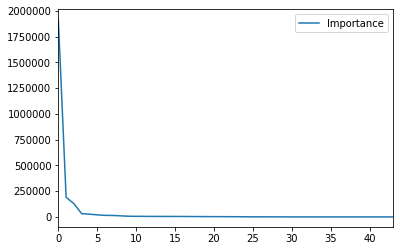

In [0]:
from azureml.interpret import ExplanationClient
from azureml.interpret.common.exceptions import ExplanationNotFoundException
# Get model explanation data
time.sleep(60) 
try:    
    explaination_client = ExplanationClient.from_run(best_run)
    if not explaination_client is None:  # TS : added if condition - 2021-05-17 12:57pm
        client = explaination_client
        engineered_explanations = client.download_model_explanation(raw=False)
        #print(engineered_explanations.get_feature_importance_dict())
        print(
            "You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n"
            + best_run.get_portal_url()
        )
        raw_explanations = client.download_model_explanation(raw=True)
        # print(raw_explanations.get_feature_importance_dict())
        print(
            "You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n"
            + best_run.get_portal_url()
        )

        feature_imp_dict = pd.DataFrame(
            raw_explanations.get_feature_importance_dict().items()
        )
        feature_imp_dict.columns = ["Feature", "Importance"]
        feature_imp_dict.plot()
    else:
        print("Explaination_client not found")
        
except ExplanationNotFoundException:
    print("Explaination_client not found  {}".format(ExplanationNotFoundException))  # TS : added if condition - 2021-05-17 12:57pm
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    #raise dbutils.notebook.exit(error) #raise the exception
    raise error #raise the exception

In [0]:

# Print feature importance

import altair as alt

alt.data_transformers.disable_max_rows()

# alt.themes.enable('fivethirtyeight') #default, latimes, ggplot2, fivethirtyeight, urbaninstitute

theme = alt.themes.enable("latimes")
theme.fontsize = 14

imp_chart = alt.Chart(source).mark_bar()

try:
    source = feature_imp_dict
    # display(source)
    title = "Forecast Model Drivers"
    fontsize = 12
    height = 600
    width = 600
    bars = (
        alt.Chart(source)
        .mark_bar()
        .encode(x="Importance:Q", y=alt.Y("Feature:O", sort="-x"))
    )  # fontSize=fontsize
    text = bars.mark_text(align="left", baseline="middle", dx=3).encode(
        text=alt.Text("Importance:Q", format=",.0f")
    )  #    fontSize=fontsiz
    imp_chart = (bars + text).properties(title=title)
    imp_chart.save(output_data_path + 'feature_importance_chart.html') # for png, scale_factor=2.0)
except NameError as error:   # TS : added if condition - 2021-05-17
    print(error)
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    #raise dbutils.notebook.exit(error) #raise the exception
    raise error #raise the exception

imp_chart


Out[106]:

In [0]:
#**********************************************************DONE*************************************************************
print("Model processing completed")

Model processing completed

In [0]:
'''
#Operationalization means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.
description = 'AutoML Revenue forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

#Develop the scoring script
#For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

#Deploy the model as a Web Service on Azure Container 
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': 'automl-forecasting'},
                                               description = 'Automl forecasting revenue service')

aci_service_name = 'automl-revenue-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

aci_service.get_logs()

#Call the service
import json
X_query = X_test.copy()
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)
    
y_fcst_all.head()    

#Delete the web service if desired
#serv = Webservice(ws, 'automl-revenue-forecast-01')
#serv.delete()     # don't do it accidentally
'''

Out[108]: "\n#Operationalization means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.\ndescription = 'AutoML Revenue forecaster'\ntags = None\nmodel = remote_run.register_model(model_name = model_name, description = description, tags = tags)\n\nprint(remote_run.model_id)\n\n#Develop the scoring script\n#For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.\nscript_file_name = 'score_fcast.py'\nbest_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)\n\n#Deploy the model as a Web Service on Azure Container \nfrom azureml.core.model import InferenceConfig\nfrom azureml.core.webservice import AciWebservice\nfrom azureml.core.webservice import Webservice\nfrom azureml.core.model import Model\n\ninference_config = InferenceConfig(environment = best_run.get_environment(), \n entry_script = script_file_name)\n\naciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, \n memory_gb = 2, \n tags = {'type': 'automl-forecasting'},\n description = 'Automl forecasting revenue service')\n\naci_service_name = 'automl-revenue-forecast-01'\nprint(aci_service_name)\naci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)\naci_service.wait_for_deployment(True)\nprint(aci_service.state)\n\naci_service.get_logs()\n\n#Call the service\nimport json\nX_query = X_test.copy()\n# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.\nX_query[time_column_name] = X_query[time_column_name].astype(str)\n# The Service object accept the complex dictionary, which is internally converted to JSON string.\n# The section 'data' contains the data frame in the form of dictionary.\ntest_sample = json.dumps({'data': X_query.to_dict(orient='records')})\nresponse = aci_service.run(input_data = test_sample)\n# translate from networkese to datascientese\ntry: \n res_dict = json.loads(response)\n y_fcst_all = pd.DataFrame(res_dict['index'])\n y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')\n y_fcst_all['forecast'] = res_dict['forecast'] \nexcept:\n print(res_dict)\n \ny_fcst_all.head() \n\n#Delete the web service if desired\n#serv = Webservice(ws, 'automl-revenue-forecast-01')\n#serv.delete() # don't do it accidentally\n"